# World Data League 2022

## 🎯 Challenge
#### *Predict Waste Production for its Reduction*


## 👥 Authors
* Magdalena Brach
* Anant Pingle
* Karim Anwar

## 💻 Development

In [65]:
!pip install pystan==2.19.1.1 | grep -v 'already satisfied'
!pip install prophet | grep -v 'already satisfied'

In [66]:
import sys

!{sys.executable} -m pip install pandas_gbq | grep -v 'already satisfied'


In [98]:
import pandas as pd
import pandas_gbq as gbq
import numpy as np 
import seaborn as sns
import os, sys
# import win32com.client
import itertools
import json
import datetime as dt
from dateutil.relativedelta import relativedelta

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.make_holidays import make_holidays_df

In [3]:
%%bigquery waste_dataset
SELECT
    *
FROM `bigquery-public-data.austin_waste.waste_and_diversion`
# GROUP BY year
# ORDER BY year DESC
# LIMIT 15

Downloading: 100%|██████████| 740873/740873 [00:02<00:00, 310036.13rows/s]


The data that we are using is a filtered version of the open-source data Waste Collection & Diversion Report (daily) from Austin, our time series data starts from the year 2003 compared to the original one that starts from 2001.

First, we plotted the data and decided to filter out the load_type of waste that has the 3 most recent years of data missing.
All missing values were found only in the 'load_weight' and specifically, they were identified under the category sweeping 'SWEEPING', but we notice as well the presence of minor amounts of missing data for the other types of waste collection.
Then, we identified that 72335 values are missing for load_weight. We tried to check how many values are missing per load_type.
We analyzed each load_type over time and identified some big outliers.

When we plot the time series data for load_weight over time seen in the appendix we get this information:
- Firtly over the years we see that not all categories have data for all the years observed (2003 -2021), we observe for these plots that they are pretty random which is dificult to recognise detailed patterns, but for some of them we can see a reduction in the load_weight when we get closer to the most recent of years
- For the graphs for the patterns per month it's even more random
- Where we start looking for weekly patterns of the yaer we start seeing some kind of seasonality

We plot again over the weeks for the for the years 2019 - 2021 and we can start seeing that the line plots have a closer likelyness in types like "DEAD ANIMALS", "RECYCLING", "GARBAGE COLLECTION", etc. where oter types have no similar patterns.

In [51]:
waste_dataset.report_date = pd.to_datetime(waste_dataset.report_date)
waste_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606552 entries, 0 to 740872
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   load_id       606552 non-null  int64              
 1   report_date   606552 non-null  datetime64[ns]     
 2   load_type     606552 non-null  object             
 3   load_time     606552 non-null  datetime64[ns, UTC]
 4   load_weight   534251 non-null  float64            
 5   dropoff_site  606552 non-null  object             
 6   route_type    606552 non-null  object             
 7   route_number  606552 non-null  object             
 8   month         606552 non-null  int64              
 9   week          606552 non-null  UInt32             
 10  year          606552 non-null  UInt32             
dtypes: UInt32(2), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 52.1+ MB


In [7]:
min(waste_dataset['report_date'])

datetime.date(2003, 1, 13)

In [4]:
waste_dataset.isnull().sum()

load_id             0
report_date         0
load_type           0
load_time           0
load_weight     72335
dropoff_site        0
route_type          0
route_number        0
dtype: int64

In [5]:
waste_dataset = waste_dataset[waste_dataset['load_type'].isin(['RECYCLING - SINGLE STREAM',
                                                               'SWEEPING', 'BRUSH', 'TIRES', 'BULK',
                                                               'RECYCLED METAL', 'MIXED LITTER',
                                                               'GARBAGE COLLECTIONS', 'ORGANICS',
                                                               'LITTER', 'DEAD ANIMAL'])]
waste_dataset.set_index('load_type').isna().groupby(level=0).sum()

,load_id,report_date,load_time,load_weight,dropoff_site,route_type,route_number
load_type,,,,,,,
BRUSH,0,0,0,23,0,0,0
BULK,0,0,0,3,0,0,0
DEAD ANIMAL,0,0,0,6,0,0,0
GARBAGE COLLECTIONS,0,0,0,38,0,0,0
LITTER,0,0,0,39,0,0,0
MIXED LITTER,0,0,0,67,0,0,0
ORGANICS,0,0,0,16,0,0,0
RECYCLED METAL,0,0,0,0,0,0,0
RECYCLING - SINGLE STREAM,0,0,0,40,0,0,0


In [8]:
waste_dataset.report_date = pd.to_datetime(waste_dataset.report_date)
waste_dataset['month'] = waste_dataset.report_date.dt.month
waste_dataset['week'] = waste_dataset.report_date.dt.isocalendar().week
waste_dataset['year'] = waste_dataset.report_date.dt.isocalendar().year

We checked the total weight of waste per category of collection service provided by Austin Resource Recovery. We see high correlation (correlation > 0.5 or correlation < 0.5) between the categories (Bulk, Garbage collection), (Garbage collection, Recycling - single stream), (Garbage collection, Sweeper dumpsites), (Garbage collection, Yard trimmings), (Garbage collection, Brush), (Yard trimmings - organic, On call bulk), (Yard trimmings organic, recycling dead end). This tells us that there is a similar pattern in the amount of waste that is collected using these categories.

In [80]:
query = """SELECT 
BULK	,
RECYCLING__SINGLE_STREAM	,
SWEEPER_DUMPSITES	,
GARBAGE_COLLECTION	,
YARD_TRIMMINGS	,
BRUSH,
YARD_TRIMMINGSORGANICS	,
STREET_CLEANINGBLVD	,
ON_CALL_BULK	,
LITTER_CONTROL	,
KAB	,
STREET_CLEANINGSPECIAL_PROJECTS	,
DEAD_ANIMAL	,
SPECIAL_PROJECT_LC	,
RECYCLING_DEAD_END	,
STREET_CLEANINGDOWNTOWN	,
SPECIAL_PROJECT_BU	,
STREET_CLEANINGRESIDENTIAL	,
RECYCLING	,
CAP_STORM	,
STORM	,
INHOUSE__RECYCLING	,
SPECIAL_EVENTS	,
LITTER_PU	,
HAULING	,
SPECIAL_PROJECT_YT	,
CAP_BULK	,
YARD_TRIMMINGSSTORM_CLEANUP	,
CAP_BRUSH	,
STREET_CLEANINGSCHOOLS	,
CAP_STORM_BR	,
STREET_CLEANINGSXSW	,
CAP_STORM_BU	,
OUT_OF_CYCLE_BULK	,
OUT_OF_CYCLE_BRUSH	,
RECYCLING__PILOT	,
SPECIAL_PROJECT_BR	,
STREET_CLEANINGBIKE_LANES	,
STORM_SWEEPING	,
ALLEY_BULK_REMOVAL	,
FLUSHER
FROM hazel-aquifer-343509.waste_dataset.waste_data_route_type_pivot"""
# Read and clean dataframe 
df = gbq.read_gbq(query).fillna(0)

Downloading: 100%|██████████| 5591/5591 [00:01<00:00, 3550.10rows/s]


<AxesSubplot:>

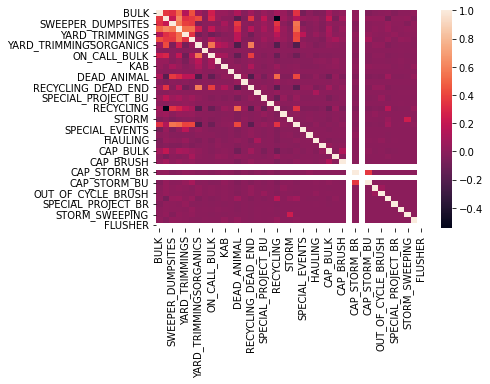

In [73]:
# Change to all floats 
df = df.astype(np.float64)
df_corr = df.corr()
sns.heatmap(df_corr)

We checked the total weight of waste dropped off at different locations (dropoff_sites). We see high correlation (correlation > 0.5) between the locations (hornsby_bend, Tds_landfill), (Winnebago, inspirationgunnisan). This tells us that there is a similar pattern in the amount of waste that is dropped at these locations

In [81]:
# Dropoff sites 
query_dropoff = """
SELECT 
TDS_LANDFILL	,
TDS__MRF	,
BALCONES_RECYCLING	,
HORNSBY_BEND	,
ORGANICS_BY_GOSH	,
ONION_CREEK	,
AUSTIN_IRON_AND_METAL	,
MRF	,
GREAT_NORTHERN	,
ON_ROUTE_HIGH_DUMP	,
PARK_CENTER	,
STEINER_LANDFILL	,
COMMERCIAL_METALS	,
WILCAB	,
BURGER_CENTER	,
WINNEBAGO	,
ELMONT	,
BRAKER_SITE	,
WESTFIELD	,
ZILKER	,
CROSS_PARK	,
BFI_LANDFILL	,
BARTON_SKYWAY	,
CLARKSON	,
PEASE_PARK	,
PARK_BEND	,
KRAMER	,
ST_EDWARDS	,
INSPIRATIONGUNNISAN	,
AUSTIN_WOOD_RECYCLING	,
CYCLED_PLASTICS_LTD	,
BALCONES_WOODS	,
LITTER_DROPOFF	,
DEEP_EDDY_PARK	
FROM hazel-aquifer-343509.waste_dataset.waste_data_dropoff_site_pivot
"""
df_dropoff = gbq.read_gbq(query_dropoff).fillna(0)

Downloading: 100%|██████████| 5591/5591 [00:01<00:00, 4479.15rows/s]


<AxesSubplot:>

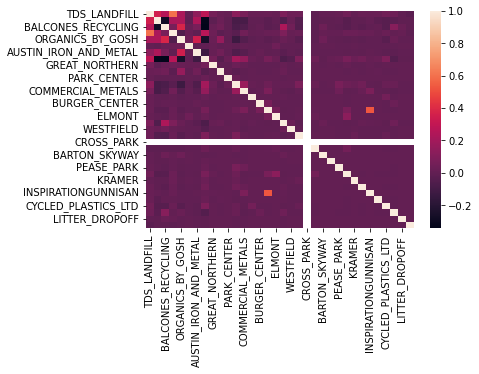

In [75]:
df_dropoff = df_dropoff.astype(np.float64)
df_dropoff_corr = df_dropoff.corr()
sns.heatmap(df_dropoff_corr)

In [82]:
df_full = gbq.read_gbq("SELECT * FROM hazel-aquifer-343509.waste_dataset.waste_data_austin")

Downloading: 100%|██████████| 740873/740873 [00:57<00:00, 12931.34rows/s]


In [83]:
df_full['Report_Date'] = pd.to_datetime(df_full['Report_Date'])
df_full['year'] = df_full['Report_Date'].dt.isocalendar().year

In [84]:
df_transformed = df_full[df_full.year.isin([2018, 2019, 2020])].groupby("Route_Number", as_index=False).agg({"Load_Weight": "sum"})

In [85]:
df_transformed["Load_Weight"] = df_transformed["Load_Weight"].astype(np.float64)

In [86]:
df_transformed = df_transformed.sort_values("Load_Weight", ascending=False).head(10)

<BarContainer object of 10 artists>

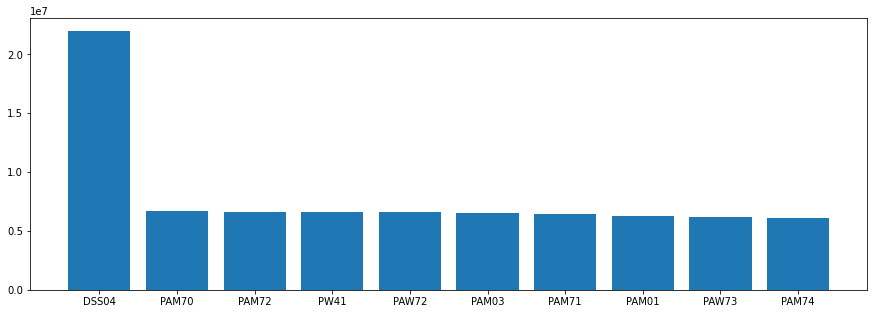

In [87]:
plt.figure(figsize = (15, 5))
plt.bar(df_transformed["Route_Number"], df_transformed["Load_Weight"])
# addlabels(df_transformed["Route_Number"], df_transformed["Load_Weight"])

## 🖼️ Visualisations


We have decided to use Prophet library for modeling because it allows fast, automated forecasting that can by easily tuned. It is not the most advanced procedure for forecasting time series, but we wanted to use something relatively simple and easy to explain. Moreover, Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. This allows us to save some time on dealing with outliers and sporadic missing values that we would take care of if we had more time disponible. 
By default, the forecast is split by the following components: trend, yearly seasonality, and weekly seasonality of the time series. It is also possible to include the holidays. We took advantage of built-in holidays for US, as we think that there might be different patterns for those days.
Prophet offers functionality for cross validation to calculate and measure error of the forecast using historical data. This procedure includes selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then, the forecasted and actual values are compared.
We used cross-validation for tuning hyperparameters of the models. For that we created a grid with the following values that allow to explore different models with quite ‘conservative’ parameters:
- changepoint_prior_scale: 0.1, 0.01, 0.001 - It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints.
- fourier: 1, 3 - This parameter controls the flexibility of the seasonality.
- SeasonalityMode: 'multiplicative', 'additive' – Controls what type of seasonality will be used 
- LogarithmicScale: True, False – Controls in logarithmic scale will be applied on the data
- BankHolidays: True, False – Controls if the holidays will be included

We are aware that more extensive hyperparameters optimization would be desired. However, due to time constraint we limited our search to the one presented above.
As a statistic of the prediction performance, we decided to use root mean squared error (RMSE). However, Prophet offers various other statistics. They are computed on a rolling window of the predictions. In our case we chose 30 days prediction horizon and we decided to get mean of the statistic over all horizon as the final value that would decide on a winning model.
We also decided to visualize the cross validation performance over the prediction horizon, in order to check if the performance is changing drastically over prediction time (horizon).

In [103]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [94]:
def forecasting(d, params):

    # Prepare different promotions and special days
    # changepoint_prior_scale - to adjust trend flexibility
    # fourier - how quickly the seasonality can change
    m = Prophet(
        # holidays = events,
        changepoint_prior_scale = params['changepoint_prior_scale'],
        daily_seasonality=False    #NEW
    ).add_seasonality(name = 'yearly',
                      period=365.25,
                      fourier_order = params['fourier'],
                      mode= params['SeasonalityMode'])
    
    if params['BankHolidays']:
        m.add_country_holidays(country_name='US')
    with suppress_stdout_stderr():
        m.fit(d)
    future = m.make_future_dataframe(periods=params['DaysToPredict'],
                                     freq='D')
    
    forecast = m.predict(future)

    return m, forecast, future

In [95]:
def ForecastToOutput(forecast, parameters):

        # To daily
        dates = pd.DataFrame(pd.date_range(start = parameters['end_datum'], periods =  parameters['WeeksToPredict']*7, freq = 'D'), columns = {'datum'})
        dates['week'] = dates['datum'].dt.isocalendar().week
        daily = dates.merge(forecast[forecast.ds > parameters['end_datum']], how = 'right', left_on = 'datum', right_on = 'ds')
        daily['weekday'] = daily['datum'].dt.dayofweek
        daily['week'] = daily['datum'].dt.isocalendar().week

        daily_prediction = daily[['datum', 'week', 'weekday', 'yhat']][:parameters['DaysToPredict']]
        daily_transpose = daily_prediction.T
        new_header = daily_transpose.iloc[0]
        daily_transpose = daily_transpose[1:] 
        daily_transpose.columns = new_header 

        return daily_transpose, daily_prediction

In [114]:
analyse_plots = True


param_grid = {  
    'WeeksToPredict'          : [11],
    'DaysToPredict'           : [21],
    'WindowHoliday'           : [7],
    'end_datum'               : ['2021-07-01'],
    'start_datum'             : ['2018-01-01'],
    'WeeksBetweenPeriods'     : [20],
    'Mode'                    : ['Predict'],
    # 'Mode'                    : ['CrossValidate'],
}


parameters = {
    'RECYCLING - SINGLE STREAM': {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['RECYCLING - SINGLE STREAM'],

},
    
    'SWEEPING': {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['SWEEPING'],

}, 
    
    'BRUSH': {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['BRUSH'],


},  
    'TIRES' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.1],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['TIRES'],

}, 
    'BULK' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['multiplicative'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['BULK'],

},
    'RECYCLED METAL' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['RECYCLED METAL'],

},
    'MIXED LITTER' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['MIXED LITTER'],

},
    'GARBAGE COLLECTIONS' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['GARBAGE COLLECTIONS'],

},
    'ORGANICS' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.001],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['ORGANICS'],
},
    'LITTER' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' : [0.01],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['LITTER'],
},
    'DEAD ANIMAL' : {
    'BankHolidays'            : [False],
    'changepoint_prior_scale' :  [0.01],
    'SeasonalityMode'         : ['additive'],
    'fourier'                 : [1],
    'LogarithmicScale'        : [False],
    'load_type'         : ['DEAD ANIMAL'],        
}     
                 }

forecast_frq = 'daily'

In [ ]:
excel_daily = pd.DataFrame()
count = 0
mapes = {}
df_error = pd.DataFrame()
hist_daily = {}

excel_weekly = pd.DataFrame()
excel_daily = pd.DataFrame()
count = 0
mapes = {}
df_error = pd.DataFrame()
hist_daily = {}
perfor = {}

for i in parameters:
    print(parameters.keys())
    print(i)
    
    tt = parameters[i].copy()
    tt.update(param_grid)
    allparams = [dict(zip(tt.keys(), v)) for v in itertools.product(*tt.values())]
    
    for params in allparams:
        load = waste_dataset[waste_dataset.load_type == params['load_type']]#.groupby(['report_date'])['load_weight'].sum()
        #d.rename(columns={"report_date": "datum", "B": "c"})
        
        Grouped = load.groupby([pd.Grouper(key='report_date', freq= 'D')])[['load_weight']].sum().reset_index()
        all_weeks = pd.DataFrame(pd.date_range(params['start_datum'], params['end_datum'], freq = 'D'), columns = {'report_date'})
        df_fc = Grouped.merge(all_weeks, how = 'outer', on = 'report_date').fillna(0).sort_values(by = 'report_date').rename(columns = {'report_date' : 'ds',
                                                                          'load_weight' : 'y'})
        if params['LogarithmicScale']:
            df_fc['y'] = df_fc['y'].apply(lambda x: np.log(x) if x > 0 else np.log(x+1))

        if params['Mode'] == 'Predict':
            m, fc, future = forecasting(df_fc, params)                                                                      
            fc = fc.set_index('ds')     

            if params['LogarithmicScale']:
                df_fc['y'] = np.round(np.exp(df_fc['y']),0)
                fc = np.round(np.exp(fc),4)

            #??????????????????????????????????????????????????????? manualy change negative to 0 and then take last forecast?
            fc.reset_index(level=0, inplace=True)
            fc.loc[fc.yhat < 0, 'yhat'] = 0
            fc.yhat = fc.yhat.replace(to_replace=0, method='ffill')

            
               
            if forecast_frq == 'daily':            
                daily_t, daily_output = ForecastToOutput(fc, params)

                if count == 0:
                    excel_daily = excel_daily.append(daily_t.rename(index = {'Waste_daily': i}))
                else:
                    excel_daily = excel_daily.append(daily_t.rename(index = {'Waste_daily': i}).drop(['week', 'weekday'], axis = 0))

                count += 1
#####################################            
            
            
            if analyse_plots == True:

                m.plot_components(fc)

                df_fc['week'] = df_fc.ds.dt.isocalendar().week.astype(int)
                df_fc['year'] = df_fc.ds.dt.isocalendar().year
#                 to_plot = daily_output.append(df_fc.tail(1).rename(columns = {'Colli': 'colli'})[['ds', 'week', 'colli']]).sort_values(by = 'ds')
                to_plot = daily_output.rename(columns = {'datum':'ds'})[['ds', 'week', 'yhat']].sort_values(by = 'ds')

                # to add sundays to the plot
                # dates = pd.DataFrame(pd.date_range(start = params['end_datum'], periods =  params['DaysToPredict'], freq = 'D'), columns = {'datum'})
                # dates['week'] = dates['datum'].dt.isocalendar().week
                # daily = dates.merge(to_plot[to_plot.ds > params['end_datum']], how = 'left', left_on = 'datum', right_on = 'ds')
                daily = to_plot[to_plot.ds > params['end_datum']].rename(columns={'ds' : 'datum'})
                daily['week'] = daily['datum'].dt.isocalendar().week.astype(int)
                daily['yhat'] = daily['yhat'].fillna(0)
                to_plot = daily
                
                plt.figure(figsize = (8,5))
                plt.style.use('ggplot')


                plt.plot(df_fc[df_fc.year == 2020].week.astype(int), df_fc[df_fc.year == 2020].y, label = '2020', color = 'brown', alpha = 0.5)
#                 plt.plot(df_fc[df_fc.jaar == 2018].week.astype(int), df_fc[df_fc.jaar == 2018].y, label = '2018')
#                 plt.plot(df_fc[df_fc.jaar == 2019].week.astype(int), df_fc[df_fc.jaar == 2019].y, label = '2019')
                plt.plot(to_plot.week.astype(int), to_plot.yhat, label = '2021 prediction', color = 'b', linestyle = '--', marker = '.')
                plt.plot(df_fc[df_fc.year == 2021].week.astype(int), df_fc[df_fc.year == 2021].y, label = '2021', color = 'b')
                plt.ylabel('Waste Load Weight')
                plt.xlabel('Week')
                plt.xticks(ticks = np.arange(1,52,3))
                plt.title(params['load_type'])
                plt.legend()
        

                temp = load.groupby(['report_date'])[['load_weight']].sum().reset_index()
                starting_plot_date =  (pd.to_datetime([params['end_datum']]) - dt.timedelta(days = 28))[0]
                to_plot_daily = temp[temp.report_date > starting_plot_date].rename(columns = {'report_date' : 'datum'})
                fc_daily= daily_output[['datum', 'yhat']].sort_values(by = 'datum')#.rename(columns = {'report_date' : 'datum'})


                ## to add sundays to the plot
                # dates = pd.DataFrame(pd.date_range(start = params['end_datum'], periods =  params['DaysToPredict'], freq = 'D'), columns = {'datum'})
                # dates['week'] = dates['datum'].dt.isocalendar().week
                # daily = dates.merge(fc_daily[fc_daily.datum > params['end_datum']], how = 'left', left_on = 'datum', right_on = 'datum')
                # daily['weekday'] = daily['datum'].dt.dayofweek 
                # fc_daily = daily
                
                plt.figure(figsize = (10,5))
                plt.plot(fc_daily.datum, fc_daily.yhat, label = '2021 Prediction', linestyle = '--', marker = '.')

                all_dates = pd.DataFrame(pd.date_range(starting_plot_date, params['end_datum'], freq = 'D'), columns = {'datum'})
                tt = to_plot_daily.merge(all_dates, how = 'outer', on = 'datum').fillna(0).sort_values(by = 'datum')
                plt.plot(tt.datum, tt.load_weight, label = '2021 data')
                plt.legend()
                plt.title(params['load_type'])
                plt.ylabel('Waste Load Weight')
                plt.xlabel('Datum')

        if params['Mode'] == 'CrossValidate':
            m, fc, future = forecasting(df_fc, params)
            fc = fc.set_index('ds')

            if params['LogarithmicScale']:
                df_fc['y'] = np.round(np.exp(df_fc['y']),3)
                fc = np.round(np.exp(fc),3)

            fc.reset_index(level=0, inplace=True)
            fc['week'] = fc.ds.dt.isocalendar().week

            days_start = (365 - df_fc.ds.min().day) + (2021 - pd.to_datetime([params['start_datum']]).year[0])*365
            print(days_start)
            cv_results = cross_validation(m, initial = str(days_start) + ' days',
                                          period = str(params['WeeksBetweenPeriods']*7) + ' days', 
                                          horizon = '30 days', 
                                          parallel = 'processes')

            if params['LogarithmicScale']:
                cv_results['yhat'] = np.round(np.exp(cv_results['yhat']),3)
                cv_results['y'] = np.round(np.exp(cv_results['y']),3)

            df_performance = performance_metrics(cv_results)
            
            mapes[json.dumps(params)] = [m, df_fc, fc, cv_results, df_performance, params]
            
            cv_results['difference'] = cv_results.ds - cv_results.cutoff    
            cv_results['week'] = cv_results.ds.dt.isocalendar().week
            cv_results['days'] = cv_results.difference.astype(str).str.split().str[0].astype(int)
            
            perfor.update({str(params) : [performance_metrics(cv_results)['rmse'].mean(), params.get('load_type')]})

dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
RECYCLING - SINGLE STREAM


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
SWEEPING


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
BRUSH


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
TIRES
dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
BULK


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
RECYCLED METAL
dict_keys(['RECYCLING - SINGLE STREAM', 'SWEEPING', 'BRUSH', 'TIRES', 'BULK', 'RECYCLED METAL', 'MIXED LITTER', 'GARBAGE COLLECTIONS', 'ORGANICS', 'LITTER', 'DEAD ANIMAL'])
MIXED LITTER


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


All EDA plots regarding the forecast can be found in the Appendix.
TIRES didn't include public holidays, so probably the holiday didn't have a huge impact on waste collection of these load types.
* RECYCLING - SINGLE STREAM: linear increasing trend since 2003, weekly seasonality shows no collection on Sunday with the highest values for Monday and Wednesday, the yearly seasonality is relatively weak and constant. It seems the model predicted weekly pattern correctly but the baseline is too high.
* SWEEPING: linear deacreasing trend, weekly seasoality shows no collection on the weekend with the highest values for Wednesday but quite similar to other days of the week. Yearly seasonality is relatively weak with the smallest numbers for August which we can confirm in our Monthly Waste plots in EDA.
* BRUSH: the trend was raising quickly until 2010 and then stabilised for the next years, weekly seasoality shows no collection on the weekend with the highest values for Tuesday and Wednesday, and smallest for Friday. Yearly seasonality is relatively weak with the smallest numbers for January which we can confirm in our Monthly Waste plots in EDA.
* TIRES: more change point in the trend that is increaing slowlu until year 2012, then decreasing until 2017 and the raising quite quickly in the following years, weekly seasoality shows no collection on the weekend with the highest values for Tuesday and Wednesday, and smallest for Friday.Yearly seasonality has the smallest numbers for March which we can confirm in our Monthly Waste plots in EDA.
* BULK: linear increasing trend  since late 2004, weekly seasonality shows no collection on Sunday with highest value on Tuesday, the yearly seasonality is relativelu weak with the smallest numbers around the month of march which coincide with our Monthly Waste plots in the EDA.
* RECLED METAL: From the years 2004 to 2006 there were high values with a sharp decrease in 2007 then stabilisation in the following years. There in weak yearly seasonality with the highest value in January.
* MIXED LITTER: Decreasing trend from 2004 until 2009 then it stabilizes until 2013 then with another sharp increase in the following years. No clear pattern in yearly seasonality.
* GARBAGE COLLECTIONS: The trend is relatively stable. Relatively weak yearly seasonality with the smallest value in Feburary and September.
* ORGANICS: This load_type started to be collected in 2018 and has an increasing trend, with a peak in March and lowest values in August.
* LITTER: A lot of change points in the trends with a peak for 2012. Yearly seasonality with the highest values for March.
* DEAD ANIMAL: Decreasig trend with a charpness in 2007 with a rapid decrease until 2012, then followed with a more steady decrease in the trend. For the yearly seasnality the highest values are in November and the lowest are in Februray.


In [ ]:
#sorting by the mean of rmse nit by load type which is secondary value  
dict(sorted(perfor.items(), key=lambda item: item[1]))

In [ ]:
perfor_df = pd.DataFrame.from_dict(perfor).T.reset_index().rename(columns={0:'rmse', 1:'load_type'})

In [89]:
perfor_df.groupby('load_type').min()

,index,rmse
load_type,,
BRUSH,"{'BankHolidays': False, 'changepoint_prior_sca...",33170.031764
RECYCLING - SINGLE STREAM,"{'BankHolidays': False, 'changepoint_prior_sca...",118966.881969
SWEEPING,"{'BankHolidays': False, 'changepoint_prior_sca...",18177.394643
TIRES,"{'BankHolidays': False, 'changepoint_prior_sca...",2063.697803


Our decision for our predictions were limited to the last 3 years from our original data starting from the year 2018 due to limitation of computing resources.

## 👓 References
List all of the external links we used in this analysis:

- https://facebook.github.io/prophet/
- https://peerj.com/preprints/3190/
- https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f
- https://www.austintexas.gov/news/city-austin-temporarily-suspend-large-brush-and-bulk-collection
- https://www.austintexas.gov/news/austin-resource-recovery-releases-2021-annual-report
- https://www.phoenix.gov/sustainability/waste

## ⏭️ Appendix


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

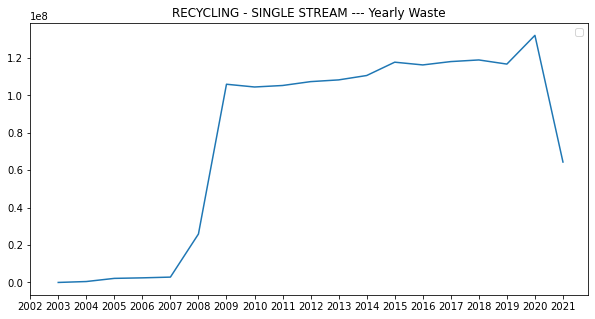

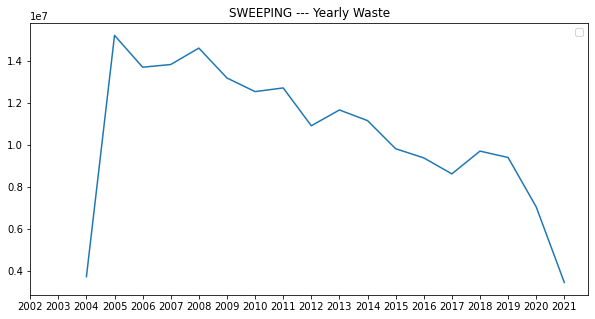

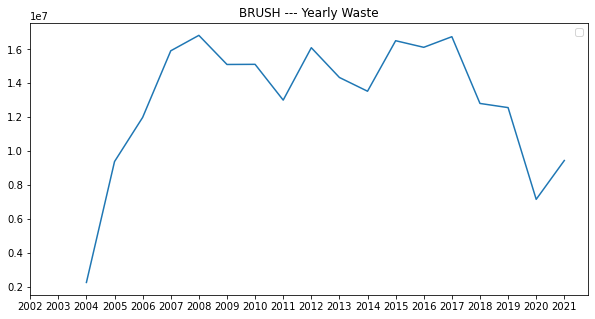

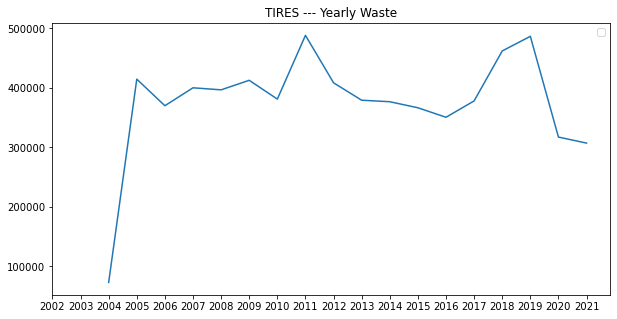

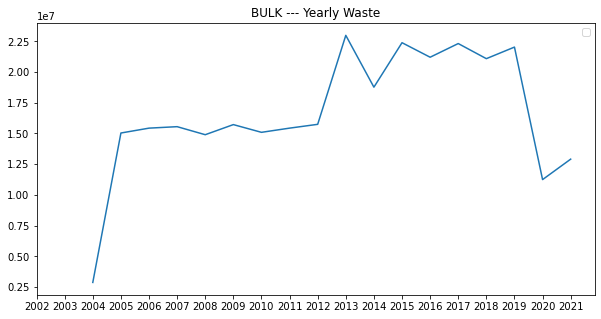

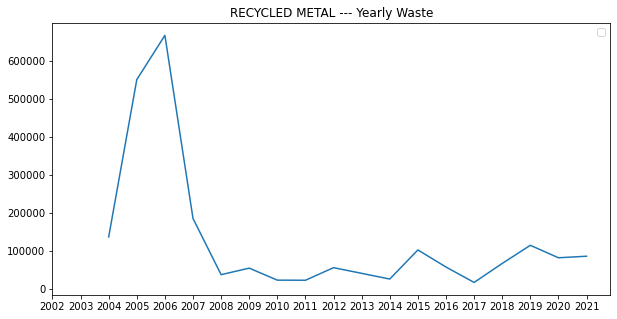

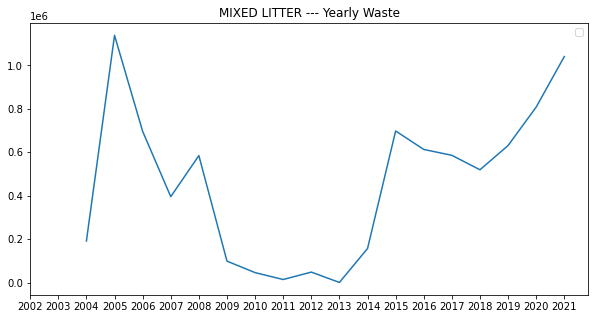

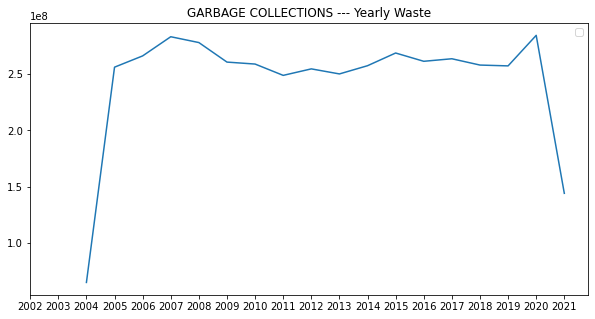

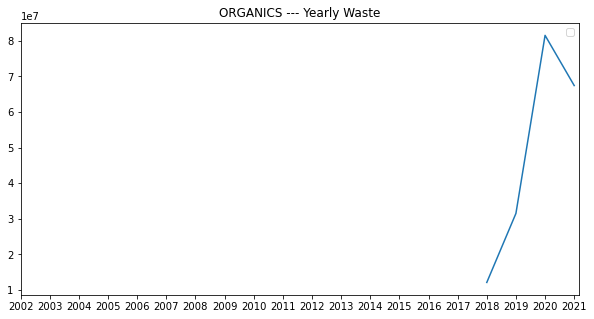

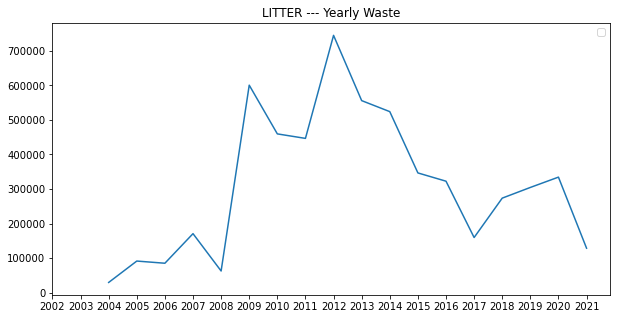

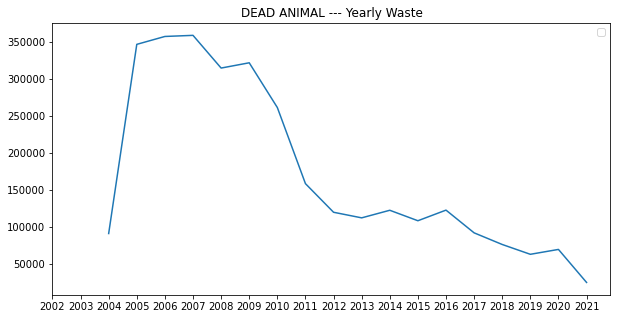

In [39]:
for r in waste_dataset['load_type'].unique():
    # print(r)
    plt.figure(figsize = (10,5))
    
                
    to_plot = waste_dataset[(waste_dataset.load_type == r)].groupby(['year'])[['load_weight']].sum().reset_index()
#         plt.plot(to_plot.week, to_plot.doosjes_werkelijk, label = 'werkelijk', color = 'b')
    
    plt.plot(to_plot.year, to_plot.load_weight)
    plt.xticks(np.arange(2002, 2022, 1))


    plt.title('{} --- Yearly Waste'.format(r))
    
    plt.legend()
   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

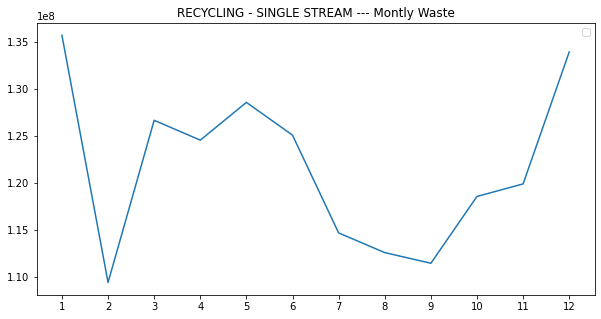

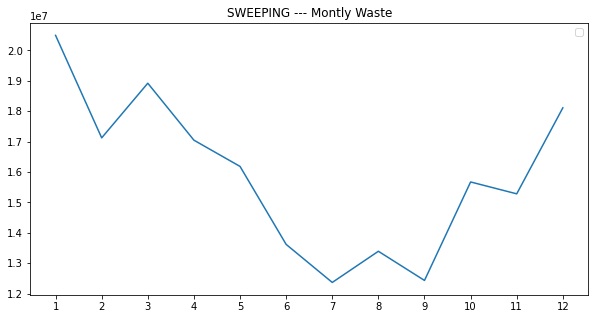

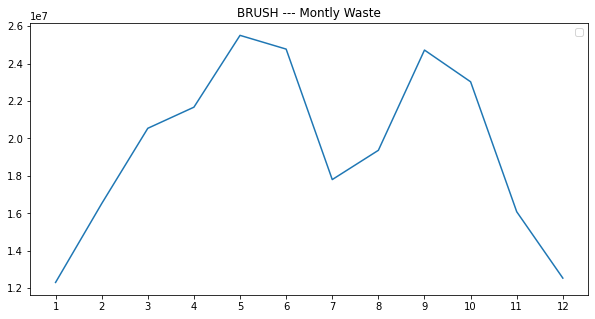

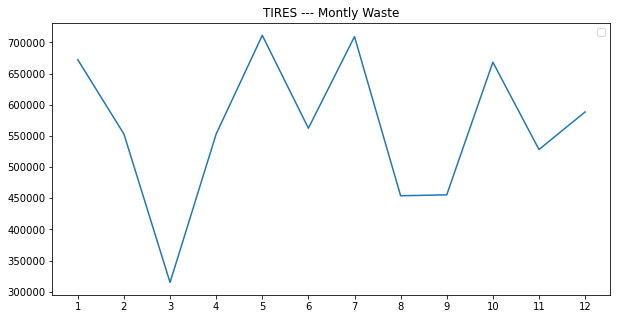

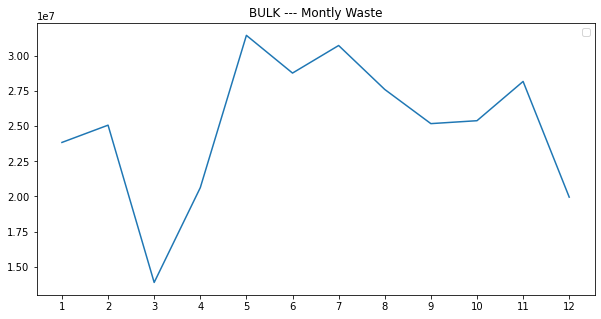

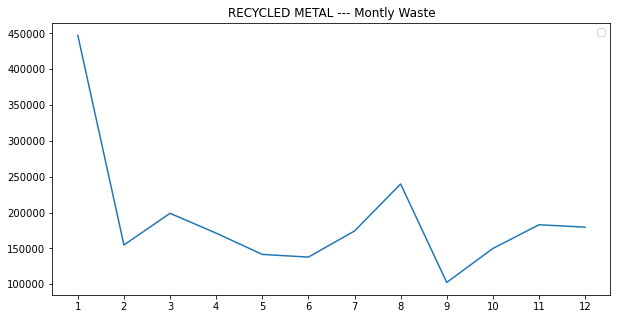

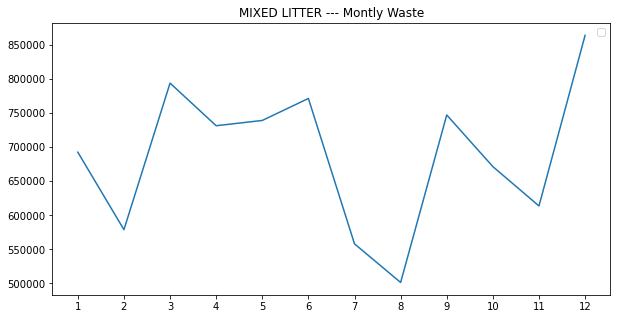

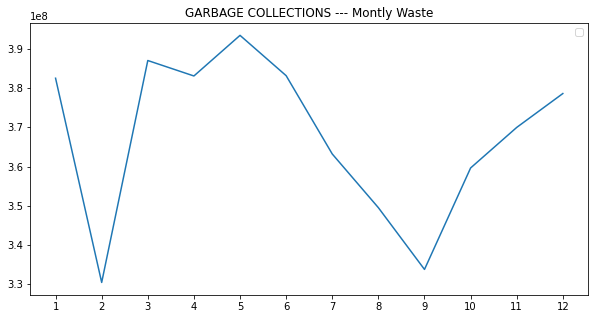

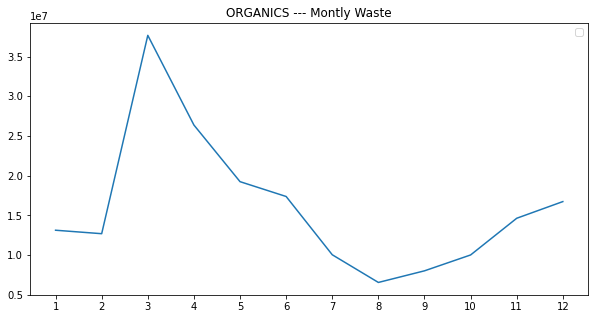

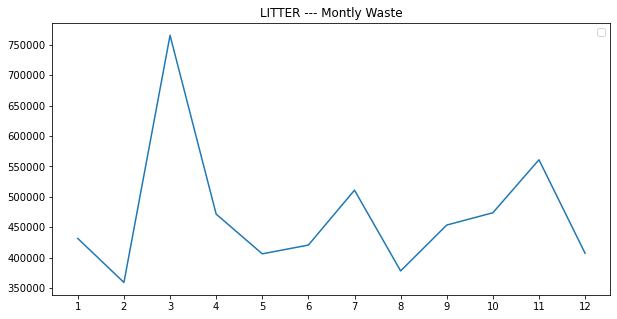

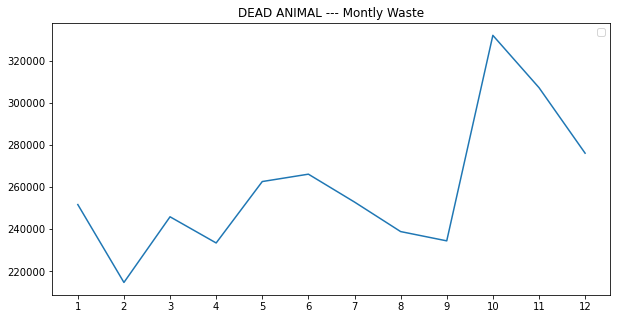

In [46]:
for r in waste_dataset['load_type'].unique():
    # print(r)
    plt.figure(figsize = (10,5))
    
                
    to_plot = waste_dataset[(waste_dataset.load_type == r)].groupby(['month'])[['load_weight']].sum().reset_index()
#         plt.plot(to_plot.week, to_plot.doosjes_werkelijk, label = 'werkelijk', color = 'b')
    
    plt.plot(to_plot.month, to_plot.load_weight)
    plt.xticks(np.arange(1, 13, 1))


    plt.title('{} --- Montly Waste'.format(r))
    
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

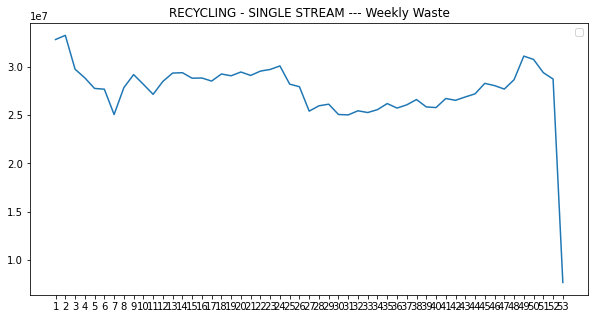

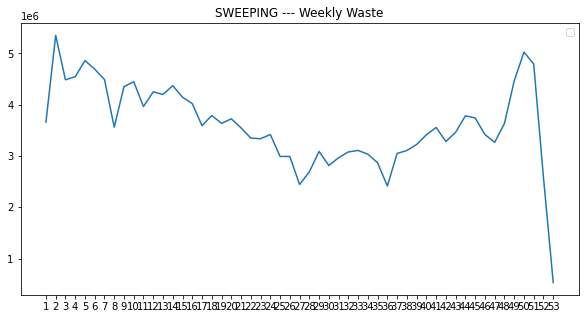

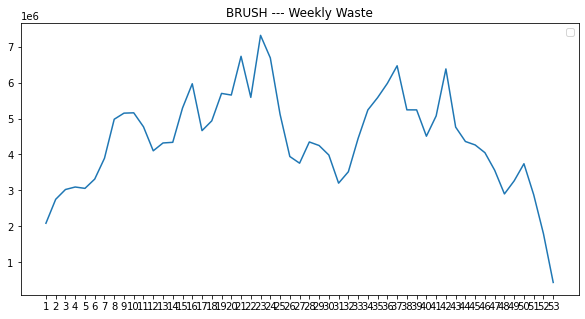

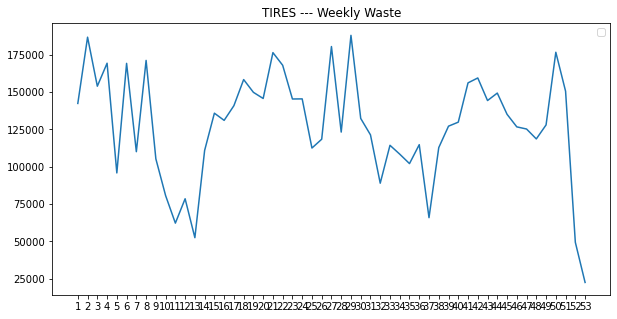

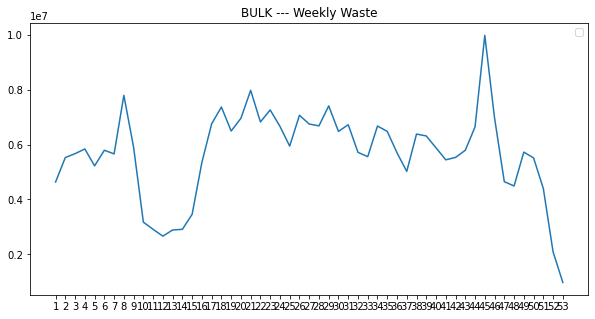

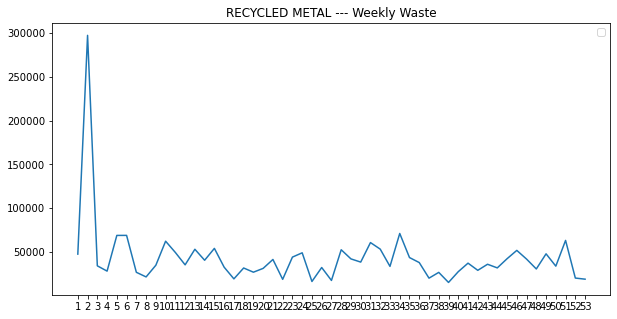

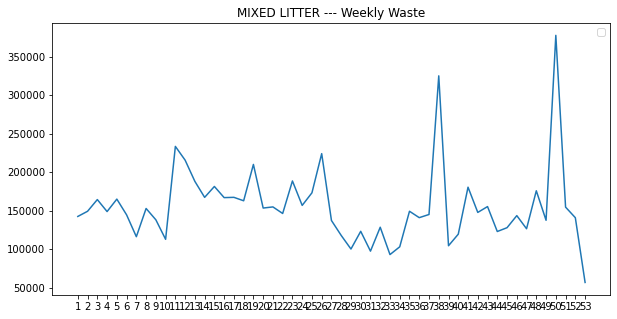

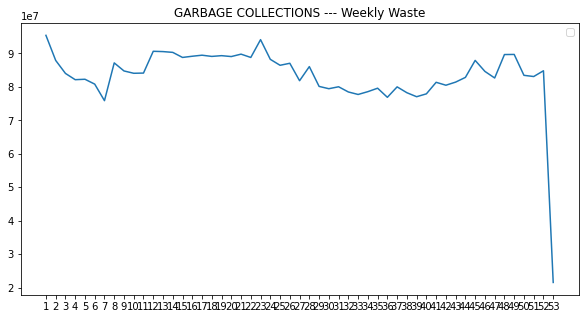

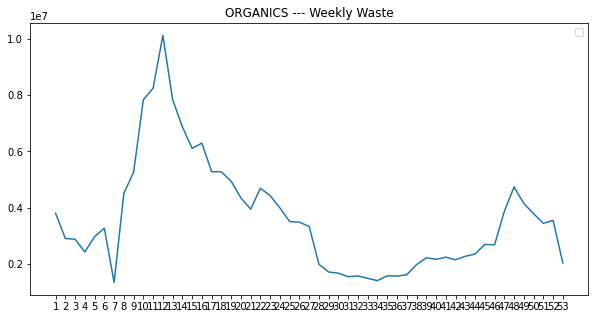

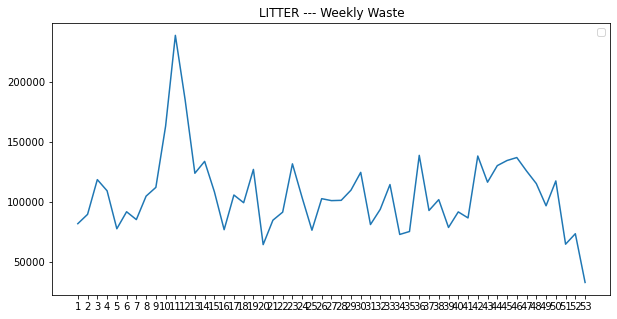

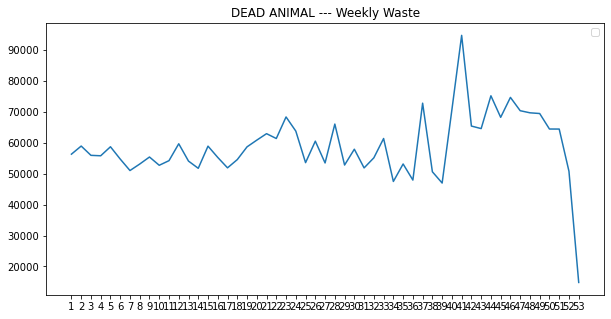

In [50]:
for r in waste_dataset['load_type'].unique():
    # print(r)
    plt.figure(figsize = (10,5))
    
                
    to_plot = waste_dataset[(waste_dataset.load_type == r)].groupby(['week'])[['load_weight']].sum().reset_index()
#         plt.plot(to_plot.week, to_plot.doosjes_werkelijk, label = 'werkelijk', color = 'b')
    
    plt.plot(to_plot.week, to_plot.load_weight)
    plt.xticks(np.arange(1, 54, 1))


    plt.title('{} --- Weekly Waste'.format(r))
    
    plt.legend()

In [9]:
types_ok = ['RECYCLING - SINGLE STREAM',
       'SWEEPING', 'BRUSH', 'TIRES', 'BULK',
       'RECYCLED METAL', 'MIXED LITTER',
       'GARBAGE COLLECTIONS', 'ORGANICS',
       'LITTER', 'DEAD ANIMAL']

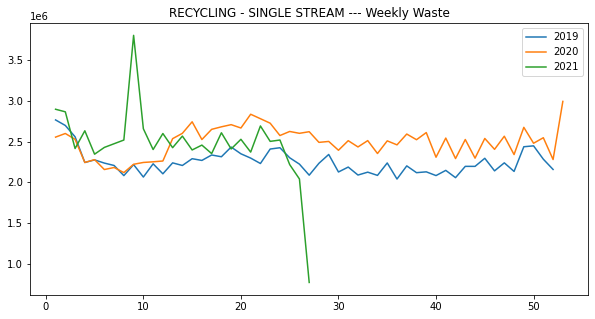

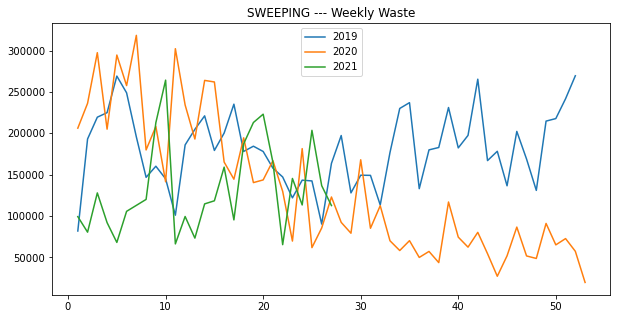

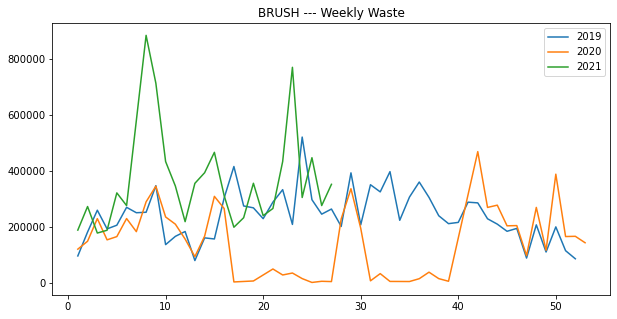

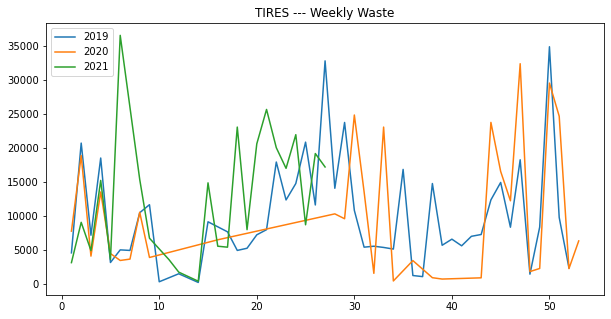

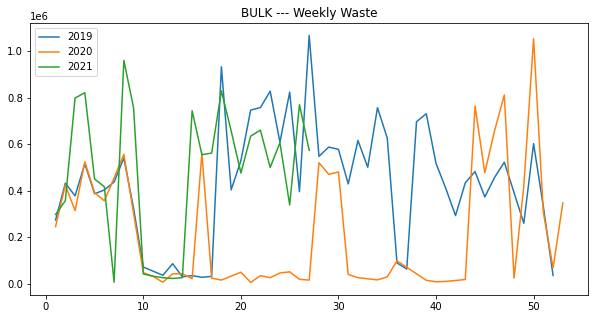

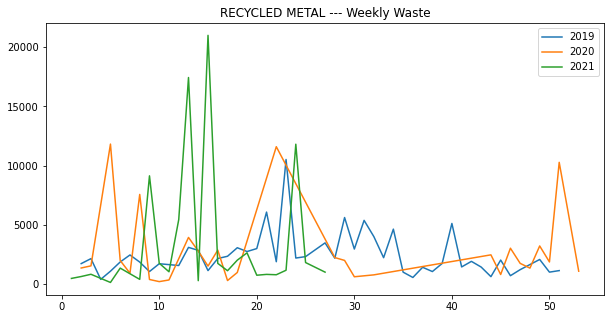

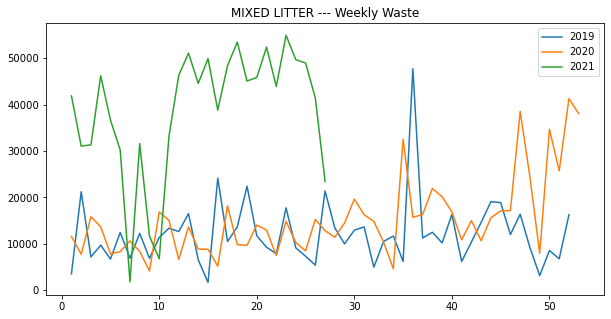

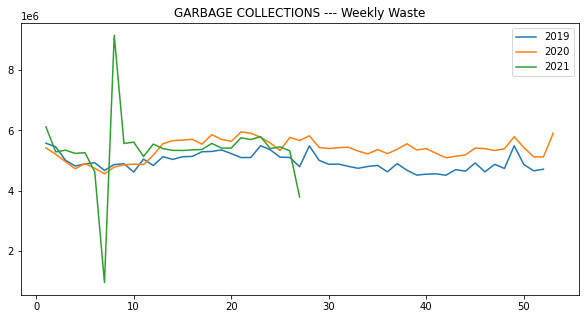

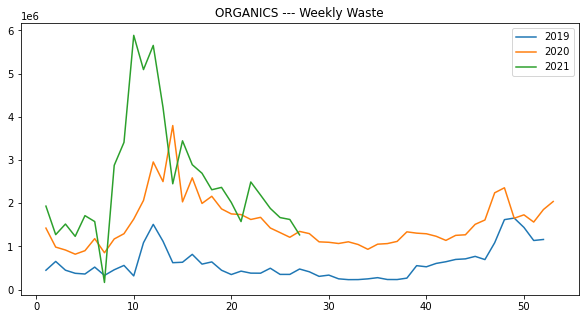

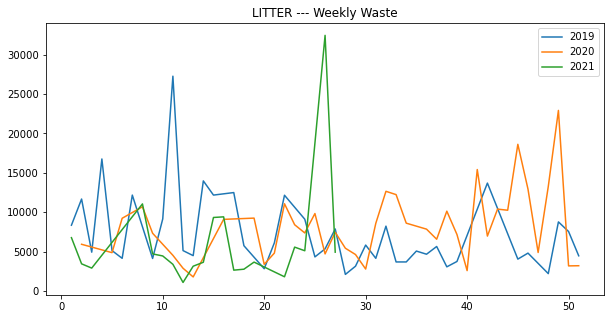

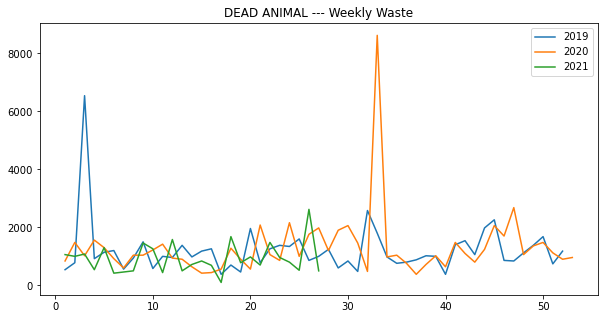

In [10]:
for r in types_ok:
    # print(r)
    plt.figure(figsize = (10,5))
    
    for q in [2019, 2020, 2021]:
                
        to_plot = waste_dataset[(waste_dataset.load_type == r) & (waste_dataset.year == q)].groupby(['week'])[['load_weight']].sum().reset_index()
#         plt.plot(to_plot.week, to_plot.doosjes_werkelijk, label = 'werkelijk', color = 'b')
        plt.plot(to_plot.week, to_plot.load_weight, label = q)


    plt.title('{} --- Weekly Waste'.format(r))

    plt.legend()

In [76]:
df_corr.style.background_gradient(cmap='coolwarm')

,BULK,RECYCLING__SINGLE_STREAM,SWEEPER_DUMPSITES,GARBAGE_COLLECTION,YARD_TRIMMINGS,BRUSH,YARD_TRIMMINGSORGANICS,STREET_CLEANINGBLVD,ON_CALL_BULK,LITTER_CONTROL,KAB,STREET_CLEANINGSPECIAL_PROJECTS,DEAD_ANIMAL,SPECIAL_PROJECT_LC,RECYCLING_DEAD_END,STREET_CLEANINGDOWNTOWN,SPECIAL_PROJECT_BU,STREET_CLEANINGRESIDENTIAL,RECYCLING,CAP_STORM,STORM,INHOUSE__RECYCLING,SPECIAL_EVENTS,LITTER_PU,HAULING,SPECIAL_PROJECT_YT,CAP_BULK,YARD_TRIMMINGSSTORM_CLEANUP,CAP_BRUSH,STREET_CLEANINGSCHOOLS,CAP_STORM_BR,STREET_CLEANINGSXSW,CAP_STORM_BU,OUT_OF_CYCLE_BULK,OUT_OF_CYCLE_BRUSH,RECYCLING__PILOT,SPECIAL_PROJECT_BR,STREET_CLEANINGBIKE_LANES,STORM_SWEEPING,ALLEY_BULK_REMOVAL,FLUSHER
BULK,1.000000,0.355460,0.323499,0.517745,0.140463,0.439544,0.069444,-0.010438,0.242432,0.040211,0.037695,0.006867,0.117171,-0.018835,0.064003,-0.013302,0.040471,0.004723,0.078629,0.043012,-0.031259,0.331452,-0.078198,-0.004561,-0.043627,-0.031761,0.080696,-0.006084,0.029636,nan,0.015366,nan,-0.032716,-0.008075,0.003545,0.010301,-0.027188,0.003173,0.000490,0.015663,nan
RECYCLING__SINGLE_STREAM,0.355460,1.000000,0.206360,0.617291,0.326904,0.358791,0.419040,-0.021768,0.284847,0.039330,-0.004413,-0.000774,-0.188103,-0.045546,0.348906,-0.015456,0.184536,-0.006585,-0.542709,0.064831,0.001861,0.136563,0.042134,0.011771,0.031568,-0.014597,0.198214,-0.061483,0.087569,nan,0.024944,nan,0.032753,0.031196,0.034167,-0.083760,0.014856,0.014773,0.025406,-0.021617,nan
SWEEPER_DUMPSITES,0.323499,0.206360,1.000000,0.568418,0.383691,0.359197,-0.052823,-0.006702,0.000866,-0.014421,0.101583,-0.001666,0.364816,-0.005378,-0.029592,0.006102,0.058426,0.014910,0.343043,0.003398,-0.050799,0.548619,-0.049961,-0.014054,0.008419,-0.031957,0.028485,0.000693,0.009900,nan,-0.019948,nan,-0.003949,0.007522,0.010055,0.038667,0.011129,0.006319,-0.026403,0.019170,nan
GARBAGE_COLLECTION,0.517745,0.617291,0.568418,1.000000,0.535111,0.540125,0.245870,-0.014857,0.188744,0.016772,0.038697,0.009235,0.298176,-0.013214,0.153586,0.004739,0.100131,0.012358,0.274361,0.045379,-0.020609,0.521272,0.020585,-0.019376,-0.000120,-0.040555,0.104653,-0.013112,0.045683,nan,-0.006545,nan,0.001642,0.018011,0.009392,0.052970,0.004493,0.007998,0.021344,0.012597,nan
YARD_TRIMMINGS,0.140463,0.326904,0.383691,0.535111,1.000000,0.336181,-0.082129,-0.015430,-0.104126,-0.055746,-0.016322,-0.000729,0.173112,-0.003830,-0.093703,0.005281,0.030205,0.029983,0.161790,0.030342,-0.007834,0.392857,0.170963,-0.012485,0.044958,-0.011625,0.084688,0.004017,0.014016,nan,0.020492,nan,0.034004,0.010899,0.000031,0.008937,0.033496,0.002895,0.007442,0.009402,nan
BRUSH,0.439544,0.358791,0.359197,0.540125,0.336181,1.000000,0.052234,-0.011192,0.135237,0.039731,0.007782,-0.005521,0.173884,-0.030017,-0.036857,-0.003543,0.068528,0.019341,0.090480,0.038788,-0.001978,0.409110,-0.002187,-0.021716,-0.012540,-0.040261,0.048074,0.099790,0.034801,nan,0.006347,nan,0.091551,-0.010971,-0.006141,0.040528,-0.010213,0.035360,0.020186,-0.004657,nan
YARD_TRIMMINGSORGANICS,0.069444,0.419040,-0.052823,0.245870,-0.082129,0.052234,1.000000,-0.007832,0.549438,0.159925,0.112364,0.034127,-0.224752,-0.015009,0.580532,-0.005720,0.017154,-0.001744,-0.200673,0.000935,-0.027466,-0.215713,0.030158,0.002685,-0.037411,-0.014907,0.017949,0.009594,-0.001147,nan,-0.011871,nan,-0.009492,0.026079,0.021290,-0.030892,-0.011319,-0.004327,-0.000717,-0.007923,nan
STREET_CLEANINGBLVD,-0.010438,-0.021768,-0.006702,-0.014857,-0.015430,-0.011192,-0.007832,1.000000,-0.005171,-0.004226,-0.006240,-0.000590,0.008602,-0.001160,-0.007079,-0.000245,-0.004746,-0.000340,0.009634,-0.001570,-0.002317,-0.008444,-0.001467,-0.001714,-0.002154,-0.000946,-0.004391,-0.001145,-0.001968,nan,-0.001290,nan,-0.001254,-0.000785,-0.000981,-0.001323,-0.000564,-0.000345,-0.000428,-0.000339,nan
ON_CALL_BULK,0.242432,0.284847,0.000866,0.188744,-0.104126,0.135237,0.549438,-0.005171,1.000000,0.097248,0.087031,-0.009104,-0.154909,-0.013073,0.377275,-0.003777,-0.025253,-0.003198,-0.132360,-0.008082,-0.025449,-0.112932,-0.020936,-0.006213

In [77]:
df_dropoff_corr.style.background_gradient(cmap='coolwarm')

,TDS_LANDFILL,TDS__MRF,BALCONES_RECYCLING,HORNSBY_BEND,ORGANICS_BY_GOSH,ONION_CREEK,AUSTIN_IRON_AND_METAL,MRF,GREAT_NORTHERN,ON_ROUTE_HIGH_DUMP,PARK_CENTER,STEINER_LANDFILL,COMMERCIAL_METALS,WILCAB,BURGER_CENTER,WINNEBAGO,ELMONT,BRAKER_SITE,WESTFIELD,ZILKER,CROSS_PARK,BFI_LANDFILL,BARTON_SKYWAY,CLARKSON,PEASE_PARK,PARK_BEND,KRAMER,ST_EDWARDS,INSPIRATIONGUNNISAN,AUSTIN_WOOD_RECYCLING,CYCLED_PLASTICS_LTD,BALCONES_WOODS,LITTER_DROPOFF,DEEP_EDDY_PARK
TDS_LANDFILL,1.000000,0.350577,0.263819,0.596396,0.227534,0.001569,0.137843,0.286386,0.055875,0.020773,0.012525,0.124155,0.067977,0.016887,0.015849,0.021122,0.012678,0.084755,0.035709,0.037590,nan,-0.014249,0.005141,0.003425,0.011121,0.040940,0.007764,0.019626,0.014381,0.022320,0.046822,0.034829,-0.002483,-0.023867
TDS__MRF,0.350577,1.000000,-0.282257,0.222635,0.233059,-0.008434,0.230715,-0.331081,-0.013575,0.029282,-0.010414,-0.090626,-0.089126,-0.002762,-0.005010,-0.025518,-0.005635,-0.057473,0.018671,-0.043296,nan,-0.017104,-0.010456,-0.007522,-0.004819,-0.033697,-0.011431,-0.010936,0.004512,-0.019222,-0.038295,-0.026224,-0.007522,-0.007522
BALCONES_RECYCLING,0.263819,-0.282257,1.000000,0.067466,0.379483,0.022969,0.067475,-0.342886,0.015413,0.042818,-0.010514,-0.073698,-0.056450,-0.009419,0.007011,-0.025740,-0.013087,0.229780,0.043043,-0.044213,nan,-0.016588,0.033171,-0.007594,-0.014800,-0.032610,-0.011541,-0.019894,-0.001950,0.002704,-0.037257,0.111493,0.019738,-0.007594
HORNSBY_BEND,0.596396,0.222635,0.067466,1.000000,-0.056790,0.023684,-0.008682,0.265856,0.029970,-0.021181,-0.003930,-0.032099,0.042960,0.002929,0.005903,0.017875,0.023797,0.082853,0.010389,0.019085,nan,-0.012426,0.008768,0.004714,0.007132,0.024330,0.025332,0.013946,0.017986,0.001747,0.020473,-0.000746,0.009312,-0.016336
ORGANICS_BY_GOSH,0.227534,0.233059,0.379483,-0.056790,1.000000,0.029624,0.345398,-0.258906,0.019714,0.159083,-0.007898,-0.126263,-0.046855,-0.012912,-0.003597,-0.019352,-0.009525,0.023674,-0.000950,-0.033265,nan,-0.012488,0.039601,-0.005705,-0.010747,-0.017537,-0.008669,-0.016286,-0.005346,-0.006795,-0.029043,0.021294,-0.003106,-0.005705
ONION_CREEK,0.001569,-0.008434,0.022969,0.023684,0.029624,1.000000,-0.005061,-0.003730,0.009057,-0.004720,-0.001450,-0.010400,0.002718,-0.002429,-0.002676,-0.003553,0.037619,-0.005378,-0.006466,-0.006217,nan,-0.002383,-0.001459,-0.001047,-0.002041,-0.005141,-0.001592,-0.003108,-0.001968,-0.002679,-0.005333,-0.005883,-0.001047,-0.001047
AUSTIN_IRON_AND_METAL,0.137843,0.230715,0.067475,-0.008682,0.345398,-0.005061,1.000000,-0.120270,0.012409,0.040053,-0.003706,-0.064614,-0.033675,-0.006208,0.009762,-0.009082,-0.004656,-0.027984,-0.002837,-0.015662,nan,-0.006089,-0.003729,-0.002677,-0.005217,-0.007639,-0.004068,-0.007943,-0.000111,-0.005295,-0.013629,-0.013396,-0.002677,-0.002677
MRF,0.286386,-0.331081,-0.342886,0.265856,-0.258906,-0.003730,-0.120270,1.000000,0.054980,-0.036723,0.021222,0.198559,0.154298,0.014374,0.002773,0.063164,0.021547,-0.065222,-0.039569,0.086090,nan,0.030580,-0.011397,0.013735,0.022829,0.069243,0.024967,0.048397,0.009935,0.023624,0.084843,-0.045751,-0.008249,-0.008249
GREAT_NORTHERN,0.055875,-0.013575,0.015413,0.029970,0.019714,0.009057,0.012409,0.054980,1.000000,-0.006632,-0.002038,0.029440,0.013090,-0.003413,-0.003760,-0.004993,-0.002560,0.010742,-0.005224,-0.001642,nan,-0.001859,-0.002050,-0.001472,-0.002869,0.009898,-0.002237,-0.004367,0.007104,-0.003765,0.002594,0.001593,-0.001472,-0.001472
ON_ROUTE_HIGH_DUMP,0.020773,0.029282,0.042818,-0.021181,0.159083,-0.004720,0.040053,-0.036723,-0.006632,1.000000,-0.001116,-0.019486,-0.010138,-0.001869,-0.002059,-0.002734,-0.001402,0.022843,-0.004975,-0.004784,nan,-0.001833,-0.001123,-0.000806,-0.001571,-0.003956,-0.001225,-0.002391,-0.001514,0.005061,-0.004103,-0.004527,-0.000806,-0.000806
